# Description

This notebook calculates the Poisson confidence of a hypothesized maximum event occurence rate ```r_hypothesis``` given the ```test_duration``` and the number of events observed ```n_events```.

When faced with the result of a continuous test (for example the number of false positives observed during 10 hours), this tells you how confident you can be that the real event occurence rate is ```r_hypothesis``` or lower, and that you didn't just get ```n_events``` during a ```test_duration``` by getting lucky and the real event occurence rate (the one you would measure if you ran the test infinitely long) being higher than your desired ```r_hypothesis```.

In addition to that the notebook produces a graph that tells you how confident you can be in real event occurence rates from a whole interval.

__Note__
1. All probabilities are given as numbers between 0 and 1, where 0 represents "never" and 1 represents 100% certainty.
2. The calculated confidences are conservative, i.e., the coverage of this hypothesis test is that of the reported confidence or higher. That means if you use this notebook for multiple tests, and it yields a confidence of 95% or more every time, then you should expect the true event occurence rate to be higher than ```r_hypothesis``` in 1/20 trials on average in the worst-case.

# Parameters

In [1]:
test_duration = 10 #measure of how long the test was run [km, hours, ...]
n_events = 0 #number of events observed during test_duration
r_hypothesis = 0.3 #hypothesized upper limit for occurence rate of the relevant event [#/km, #/hour, ...]

round_to_digits = 4

assert isinstance(test_duration, (int, float)) and test_duration > 0
assert isinstance(n_events, int) and n_events >= 0
assert isinstance(r_hypothesis, float) and r_hypothesis >= 0
assert isinstance(round_to_digits, int) and round_to_digits >= 1

# Evaluation

In [2]:
import matplotlib.pyplot as plt
import mpmath as mp
import numpy as np

mp.mp.dps = 50 #use 50 decimal digits precision in mpmath calculations

def poisson_distr(n_events, r_event, test_duration):
    e = mp.mpf(float(r_event)) * mp.mpf(float(test_duration))
    return mp.power(mp.mpf(e), n_events) / mp.fac(n_events) * mp.exp(-e)

poisson_distr_vectorized = np.vectorize(poisson_distr) #create version of poisson distribution that can be evaluated for whole lists of inputs

def poisson_confidence(n_events, r_hypothesis, test_duration):
    return 1-poisson_distr_vectorized(np.arange(0, n_events+1), r_hypothesis, test_duration).sum()

hypothesis_confidence = poisson_confidence(n_events, r_hypothesis, test_duration)
null_hypothesis_confidence = 1-hypothesis_confidence

hypothesis_confidence_rounded = mp.nstr(hypothesis_confidence, round_to_digits)
null_hypothesis_confidence_rounded = mp.nstr(null_hypothesis_confidence, round_to_digits)

print('Your test had a duration of {} during which you observed {} events.'.format(test_duration, n_events))
print('The probability of getting {} or fewer events despite the occurance rate of said event being {} or higher is {}.'.format(n_events, r_hypothesis, null_hypothesis_confidence_rounded))
print(f'Therefore, the confidence is {hypothesis_confidence_rounded} that the occurance rate of a single test is at most {r_hypothesis}.')

Your test had a duration of 10 during which you observed 0 events.
The probability of getting 0 or fewer events despite the occurance rate of said event being 0.3 or higher is 0.04979.
Therefore, the confidence is 0.9502 that the occurance rate of a single test is at most 0.3.


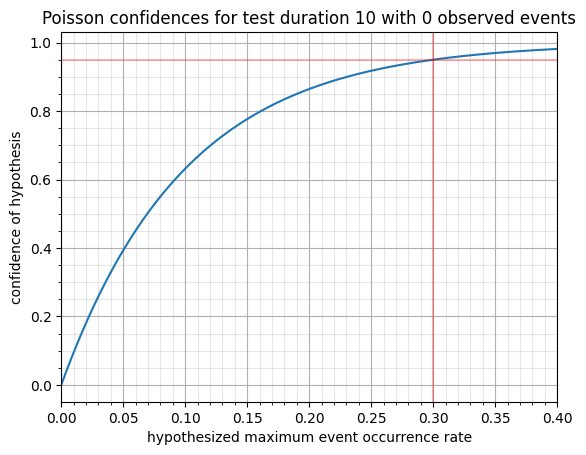

In [3]:
#create version of poisson confidence that can be evaluated for whole lists of hypothetical occurrence rates
poisson_confidence_vectorized = np.vectorize(poisson_confidence)

r_maxplot = max(r_hypothesis*1.2, 4*max(1, n_events)/test_duration)
x = np.linspace(0, r_maxplot, 1001) #list of possible single trial success probabilities. increase the number of samples here if the plot needs it
C_x = poisson_confidence_vectorized(n_events, x, test_duration) #probabilities of each of these hypotheses

#plot
plt.plot(x, C_x)
plt.axvline(r_hypothesis, 0, 1, color='red', alpha=0.3)
plt.axhline(hypothesis_confidence, 0, 1, color='red', alpha=0.3)

plt.gca().set_title('Poisson confidences for test duration {} with {} observed events'.format(test_duration, n_events))
plt.gca().set_xlabel('hypothesized maximum event occurrence rate')
plt.gca().set_ylabel('confidence of hypothesis')
plt.gca().tick_params(axis='x', which='minor', bottom=True)
plt.gca().minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', alpha=0.3);

plt.gca().set_xlim([0, r_maxplot]); #change plot range here